In [80]:
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import xray as xr
import pandas as pd
from pydownscale.data import DownscaleData
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sess = tf.InteractiveSession()


Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x115856810>> ignored


In [81]:
data = pickle.load(open("newengland_D_12781_8835.pkl", "r"))

In [102]:
max_train_year = 2004
seas = "JJA"
seasonidxs = np.where(data.observations['time.season'] == seas)[0]
X = data.get_XTensor()[seasonidxs]
Y, locs = data.get_y()
Y = Y[seasonidxs]
t = data.observations['time'][seasonidxs]

train_rows = np.where(t['time.year'] <= max_train_year)[0]
test_rows = np.where(t['time.year'] > max_train_year)[0]
ttest = t[test_rows]

Xtrain, Xtest = X[train_rows], X[test_rows]
YtrainTrue, YtestTrue = Y[train_rows], Y[test_rows]

numt, numx, numy, numc = Xtrain.shape

Xmu, Xsd = Xtrain.mean(axis=0), Xtrain.std(axis=0)
Xtrain = (Xtrain - Xmu) / Xsd
Xtest = (Xtest - Xmu) / Xsd

scale_y = StandardScaler()
scale_y.fit(YtrainTrue)
Ytrain = scale_y.transform(YtrainTrue)
Ytest = scale_y.transform(YtestTrue)

print "Image size:", numx, "by", numy

x = tf.placeholder(tf.float32, shape=[None, numx, numy, numc])
y_ = tf.placeholder(tf.float32, shape=[None, Ytrain.shape[1]])

print Ytrain.shape, Xtrain.shape

Image size: 19 by 31
(2300, 266) (2300, 19, 31, 15)


In [103]:
#As per Section 3.2, we set f1 = 9, f3 = 5, n1 = 64 
#    and n2 = 32 in our main evaluations
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def max_pool_3x3(x):
  return tf.nn.max_pool(x, ksize=[1, 3, 3, 1],
                        strides=[1, 3, 3, 1], padding='SAME')

def max_pool_6x6(x):
  return tf.nn.max_pool(x, ksize=[1, 3, 3, 1],
                        strides=[1, 3, 3, 1], padding='SAME')


# First Convolution Layer

$W_1 = c \times f_1 \times f_1 \times n_1$

$B_1$ is of length $n_1$

In [104]:
W_conv1 = weight_variable([3, 3, 15, 10])
b_conv1 = bias_variable([10])
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
h_conv1, h_pool1


(<tf.Tensor 'Relu_34:0' shape=(?, 17, 29, 10) dtype=float32>,
 <tf.Tensor 'MaxPool_31:0' shape=(?, 9, 15, 10) dtype=float32>)

# Second Convolution Layer

In [105]:
W_conv2 = weight_variable([3, 3, 10, 5])
b_conv2 = bias_variable([5])
h_conv2 =  tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
h_pool2


<tf.Tensor 'MaxPool_32:0' shape=(?, 4, 7, 5) dtype=float32>

# Output Layer


In [106]:
_, d1, d2, d3 = h_pool2.get_shape()
h2units = d1.value * d2.value * d3.value
h_pool2_flat = tf.reshape(h_pool2, [-1, h2units])

keep_prob = tf.placeholder(tf.float32)
h_pool2_drop = tf.nn.dropout(h_pool2_flat, keep_prob)

Wout = weight_variable([h2units, Ytrain.shape[1]])
b_out = bias_variable([1])

yout = tf.matmul(h_pool2_flat, Wout) + b_out 



In [108]:
loss = tf.reduce_mean(tf.square((yout - y_)))
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

for i in range(5000):
  randidx = np.random.choice(range(Xtrain.shape[0]), 200)
  if i % 100 == 0:
    train_accuracy = loss.eval(feed_dict={
        x: Xtrain[randidx], y_: Ytrain[randidx], keep_prob: 1.0})
    test_accuracy = loss.eval(feed_dict={
        x: Xtest[:100], y_: Ytest[:100], keep_prob: 1.0})
    print("step %d, training mse %g, testing mse: %g"%(i, train_accuracy, test_accuracy))
  train_step.run(feed_dict={x: Xtrain[randidx], y_: Ytrain[randidx], keep_prob: 0.80})

print("train mse %g"%loss.eval(feed_dict={
    x: Xtrain, y_: Ytrain, keep_prob: 1.0}))
print("test mse %g"%loss.eval(feed_dict={
    x: Xtest, y_: Ytest, keep_prob: 1.0}))




step 0, training mse 1.74919, testing mse: 1.78737
step 100, training mse 1.21752, testing mse: 0.989456
step 200, training mse 0.530529, testing mse: 0.83139
step 300, training mse 0.560389, testing mse: 0.800826
step 400, training mse 0.803206, testing mse: 0.787612
step 500, training mse 0.801432, testing mse: 0.783902
step 600, training mse 0.679572, testing mse: 0.780611
step 700, training mse 0.608777, testing mse: 0.780763
step 800, training mse 0.622002, testing mse: 0.793654
step 900, training mse 0.584459, testing mse: 0.781576
step 1000, training mse 0.697407, testing mse: 0.770108
step 1100, training mse 0.51896, testing mse: 0.775441
step 1200, training mse 0.432421, testing mse: 0.769931
step 1300, training mse 0.520106, testing mse: 0.783068
step 1400, training mse 0.531924, testing mse: 0.761405
step 1500, training mse 0.379031, testing mse: 0.78595
step 1600, training mse 0.521999, testing mse: 0.748134
step 1700, training mse 0.622162, testing mse: 0.77766
step 1800, 

In [109]:
idx = 10
ypred = sess.run(yout, feed_dict={x: Xtest, keep_prob: 1})


Test Mean 3.940318, Std: 8.505224
Prediction Mean 3.940318, Std: 8.505224
SpearmanrResult(correlation=0.54099148824834542, pvalue=0.0)
Pearson (0.57633723485190047, 0.0)
RMSE: 88.6212230777


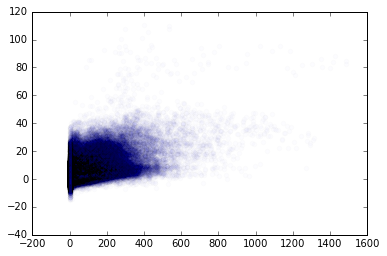

In [110]:
yhat = scale_y.inverse_transform(ypred) / 10
ytest_true = scale_y.inverse_transform(Ytest) / 10

from scipy.stats import pearsonr, spearmanr

print "Test Mean %f, Std: %f" % (yhat.mean(), ytest_true.std())
print "Prediction Mean %f, Std: %f" % (yhat.mean(), ytest_true.std())

print spearmanr(yhat.flatten(), YtestTrue.flatten())
print "Pearson", pearsonr(yhat.flatten(), YtestTrue.flatten())
print "RMSE:", np.mean((yhat - YtestTrue)**2)**(0.5)
plt.scatter(YtestTrue, yhat, alpha=0.01)


# To Netcdf

In [111]:
dfdata = []
print ypred.shape, Ytest.shape, locs.shape, t.shape
for j, (lat, lon) in enumerate(locs.values):
    for i, t1 in enumerate(ttest.values):
        d = dict(lat=lat, lon=lon, time=t1, projected=yhat[i,j], ground_truth=YtestTrue[i,j])
        dfdata.append(d)
df = pd.DataFrame(dfdata)
df.set_index(["lat", "lon", "time"], inplace=True)
dfx = xr.Dataset.from_dataframe(df)
dfx


(920, 266) (920, 266) (266, 2) (3220,)


<xray.Dataset>
Dimensions:       (lat: 24, lon: 27, time: 920)
Coordinates:
  * lat           (lat) float64 41.12 41.38 41.62 41.88 42.12 42.38 42.62 ...
  * lon           (lon) float64 286.4 286.6 286.9 287.1 287.4 287.6 287.9 ...
  * time          (time) datetime64[ns] 2005-06-01 2005-06-02 2005-06-03 ...
Data variables:
    ground_truth  (lat, lon, time) float64 0.0 0.0 0.0 87.98 0.6216 0.0 ...
    projected     (lat, lon, time) float64 0.8872 1.732 6.583 4.783 -0.6235 ...

In [112]:
dfx['error'] = dfx.projected - dfx.ground_truth
print dfx
dfx.to_netcdf("/Users/tj/repos/pydownscale/scripts/results-data/%s/CNN_D_%s.nc" % (seas, seas))




<xray.Dataset>
Dimensions:       (lat: 24, lon: 27, time: 920)
Coordinates:
  * lat           (lat) float64 41.12 41.38 41.62 41.88 42.12 42.38 42.62 ...
  * lon           (lon) float64 286.4 286.6 286.9 287.1 287.4 287.6 287.9 ...
  * time          (time) datetime64[ns] 2005-06-01 2005-06-02 2005-06-03 ...
Data variables:
    ground_truth  (lat, lon, time) float64 0.0 0.0 0.0 87.98 0.6216 0.0 ...
    projected     (lat, lon, time) float64 0.8872 1.732 6.583 4.783 -0.6235 ...
    error         (lat, lon, time) float64 0.8872 1.732 6.583 -83.2 -1.245 ...
